## 1. Load libraries - only need to do this once. 

In [1]:
# importing, data handling
import numpy as np
import pandas as pd
import ipyfilechooser
import os
import time

#import imageio
import imageio.v3 as iio
import tifffile
# import av
from PIL import Image
from skimage.color import rgb2gray

# plotting
import matplotlib  as mpl
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show, title

# thresholding
from skimage import io, color, filters, morphology, measure
from skimage.draw import rectangle_perimeter

# tracking
import trackpy as tp

from IPython.display import Video, Markdown, display

import ODLabTracker
from ODLabTracker import tracking
# from ODLabTracker.tracking import subtract_background

## 2. Setup - click run on the cell below and select an image file

In [2]:
min_area = 50 #min area of worm in pixels
max_area = 1000 #max area of worm in pixels
gap_range = 8 # max number of frame gap to link worms (i.e. can a worm disappear for more frames?)
thresh = 170 # if not 'None', then manual threshold - set to a number (see below) to use if too few worms detected or too many short tracks
search_range = 60 # max pixel distance to link tracks across frames
min_length = 5 # minimum length of track in frames to keep
frame_rate = 20 # FPS of the video - necessary for speed analysis and video writing
illumination = 1 # illumination source, 0 = white worms on dark (e.g. IR), 1 = dark worms on light. default 0
subsample = 5 # frames to keep (1/n frames), will speed up analysis of videos with a high frame rate if using centroid tracking
backsub = True # perform background subtraction using a blurred single frame. Corrects for low frequency defects (e.g. uneven illumination)
backsub_frames = 20 # number of evenly-spaced frames to subtract background

filepath = "/Users/mikeodonnell/Desktop/OP_N2-04182024152040-0000.avi"

interactive = False;
if(interactive == True):
    workingDir = os.getcwd()
    #baseDir = os.path.dirname(workingDir)

    # need to install ipyfilechooser - use pip
    from ipyfilechooser import FileChooser

    # Create and display a FileChooser widget
    fc = FileChooser(workingDir)
    print("select the first .tiff file you want to analyze")
    display(fc)
else:
    class Object(object):
        pass
    fc = Object()
    fc.selected = filepath
    fc.selected_path = os.path.splitext(filepath)[0]
    fc.selected_filename = os.path.basename(filepath)
    workingDir = os.getcwd()

display(Markdown('<strong>{}</strong>'.format("Parameter settings below")))
print(f'minimum area of worm in pixels: {min_area}')
print(f'maximum area of worm in pixels: {max_area}')
print(f'gap range of worms in frames: {gap_range}')
if thresh:
    print(f'automatically calculating threshold')
else:
    print(f'manual threshold: {thresh}')
print(f'maximum pixel distance to link worms: {search_range}')
print(f'minimum length of worm track to keep in frames: {min_length}')
print(f'frame rate to use for speed analysis: {frame_rate}')
if illumination == 0:
    print(f'analyzing light worms on dark background')
else:
    print(f'analyzing dark worms on light background')

display(Markdown('<strong>{}</strong>'.format("Once you have selected the video, run the code in the next chunk (not this one again)")))

# default values small plate on IR light:
# min_area = 200 #min area of worm in pixels
# max_area = 2000 #max area of worm in pixels
# gap_range = 8 # max number of frame gap to link worms
# thresh = None # manual threshold - use if too few worms detected or too many short tracks
# search_range = 60 # max pixel distance to link tracks across frames
# min_length = 25 # minimum length of track in frames to keep
# frame_rate = 10 # FPS - only necessary for speed analysis
# illumination = 0 # illumination source, 0 = white worms on dark (e.g. IR), 1 = dark worms on light



<strong>Parameter settings below</strong>

minimum area of worm in pixels: 50
maximum area of worm in pixels: 1000
gap range of worms in frames: 8
automatically calculating threshold
maximum pixel distance to link worms: 60
minimum length of worm track to keep in frames: 5
frame rate to use for speed analysis: 20
analyzing dark worms on light background


<strong>Once you have selected the video, run the code in the next chunk (not this one again)</strong>

## 3. Optimize input parameters - you can skip to the full analysis if you're good with your settings

In [3]:
filename = fc.selected_filename

# import just first frame to optimize file import:

import time
first_frame = iio.imread(fc.selected, index = 0)

if first_frame.shape[-1] == 3:
    display(Markdown('<strong>{}</strong>'.format("Video is RGB, need to convert to grayscale 8-bit - consider \n changing video output to this type ahead of time")))

first_frame = tracking.convert_8bit(first_frame)

image_props = iio.improps(fc.selected, plugin="pyav")
num_frames = image_props.shape[0]

if num_frames > 1000 and subsample == 1:
    print(f"You have a lot of frames in your video, consider subsampling")

start_time = time.time()
imiter_vid = iio.imiter(fc.selected, plugin = "pyav")
end_time = time.time()
print(f"Accessing video using imiter, you have {num_frames} frames, which will be subsampled every {subsample}. Determining this took {end_time - start_time} seconds")

print(f'Image appears to be resolution: {first_frame.shape[1]} x {first_frame.shape[0]} in pixels')

result_path = os.path.join(f"{os.path.splitext(fc.selected)[0]}_results")
print(f"results will be saved to {result_path}")
workingDir = os.getcwd()

background, backsub = tracking.show_background(input_video = imiter_vid, 
                                               input_file = fc.selected,
                                              first_frame = first_frame)


if backsub:
    print("subtracting background")
    backsub_frame = np.zeros(first_frame.shape, dtype=np.float32)
    print(backsub_frame.shape)
    frame_count = 0
    frame_list = np.arange(1,num_frames,num_frames/backsub_frames)
    frame_list = frame_list.astype(int)
    for i in frame_list:
        frame_to_add = iio.imread(fc.selected, index = i)
        frame_to_add = tracking.convert_8bit(frame_to_add)
        backsub_frame += frame_to_add.astype(np.float32)
        frame_count += 1
    plt.figure()
    average_frame = tracking.float_to8bit(backsub_frame)
    plt.imshow(average_frame, cmap = "gray")
    subtracted = tracking.subtract_background(frame = first_frame, average_frame = average_frame)
    plt.figure()
    plt.imshow(subtracted, cmap = "gray")
    thresh1 = filters.threshold_otsu(first_frame)
    thresh2 = np.percentile(subtracted, .5)
    print(thresh1)
    print(thresh2)
    mask1 = first_frame < thresh1
    mask2 = subtracted < thresh2
    print(np.mean(subtracted))
    print(np.median(subtracted))
    print(np.percentile(subtracted, .5))
    plt.figure()
    plt.imshow(mask1, cmap = "gray")
    plt.figure()
    plt.imshow(mask2, cmap = "gray")
    thresh = thresh2





<strong>Video is RGB, need to convert to grayscale 8-bit - consider 
 changing video output to this type ahead of time</strong>

AttributeError: module 'ODLabTracker.tracking' has no attribute 'convert_8bit'

Rendering 50 frames for threshold visualization


<strong>There should be white worms on black background, 
in the video there should be a box around all worms.
If not, you may need to adjust the threshold value manually
</strong>

255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
255 0
Converting frames using imiter of video took 46.948731899261475 seconds
results will be saved to /Users/mikeodonnell/Desktop/OP_N2-04182024152040-0000_results
Manual threshold value is 3.0
Mean area of objects in pixels is 255.0


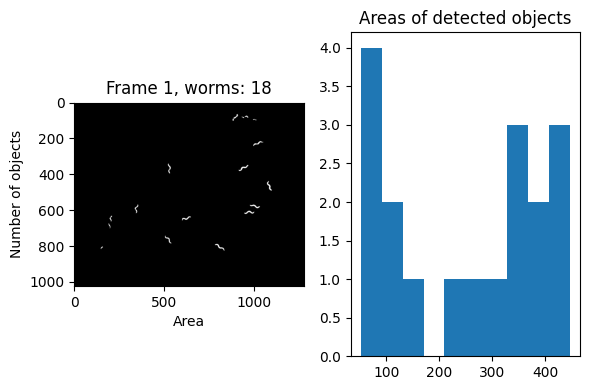

873


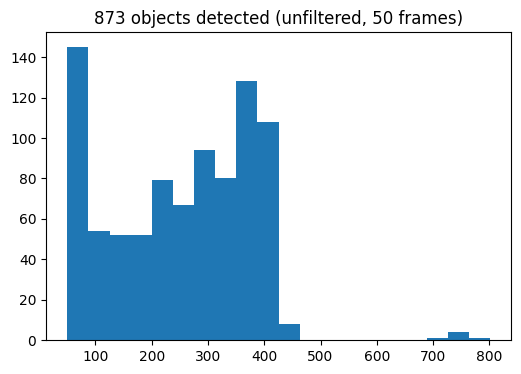

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...', height='320', wid…

In [4]:
max_frames = 50
print(f'Rendering {max_frames} frames for threshold visualization')

display(Markdown('<strong>{}</strong>'.format("There should be white worms on black background, \nin the video there should be a box around all worms.\nIf not, you may need to adjust the threshold value manually\n")))

tracking.process_video(min_area, 
                       max_area, 
                       thresh=thresh, 
                       input_video=imiter_vid, 
                       output_path=result_path, 
                       save_as="tif", 
                       max_frames=max_frames,
                       fps=frame_rate,
                      illumination=illumination,
                      subsample = subsample,
                      backsub = backsub,
                      background = background,
                      average_frame = average_frame)
from ipywidgets import Video
Video.from_file(os.path.join(result_path,"worms_annotated.mp4"), width=480, height=320)

## 4. Run for the whole video after converting to 8-bit grayscale

Keeping frame: 0255 0
Keeping frame: 5255 0
Keeping frame: 10255 0
Keeping frame: 15255 0
Keeping frame: 20255 0
Keeping frame: 25255 0
Keeping frame: 30255 0
Keeping frame: 35255 0
Keeping frame: 40255 0
Keeping frame: 45255 0
Keeping frame: 50255 0
Keeping frame: 55255 0
Keeping frame: 60255 0
Keeping frame: 65255 0
Keeping frame: 70255 0
Keeping frame: 75255 0
Keeping frame: 80255 0
Keeping frame: 85255 0
Keeping frame: 90255 0
Keeping frame: 95255 0
Keeping frame: 100255 0
Keeping frame: 105255 0
Keeping frame: 110255 0
Keeping frame: 115255 0
Keeping frame: 120255 0
Keeping frame: 125255 0
Keeping frame: 130255 0
Keeping frame: 135255 0
Keeping frame: 140255 0
Keeping frame: 145255 0
Keeping frame: 150255 0
Keeping frame: 155255 0
Keeping frame: 160255 0
Keeping frame: 165255 0
Keeping frame: 170255 0
Keeping frame: 175255 0
Keeping frame: 180255 0
Keeping frame: 185255 0
Keeping frame: 190255 0
Keeping frame: 195255 0
Keeping frame: 200255 0
Keeping frame: 205255 0
Keeping frame:

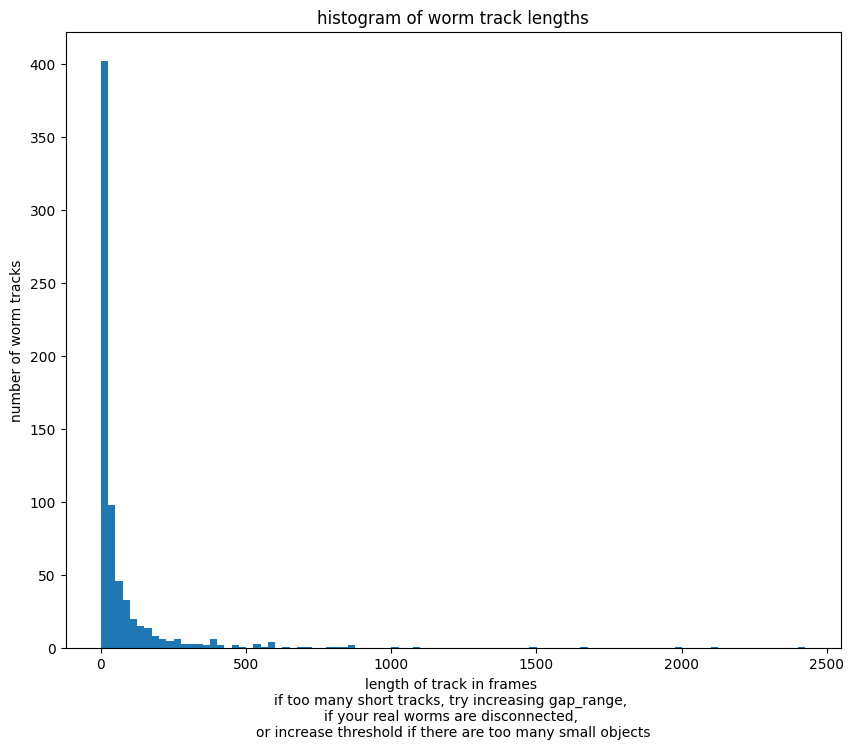

removing tracks shorter than 5 frames
plotting linked and filtered worm tracks


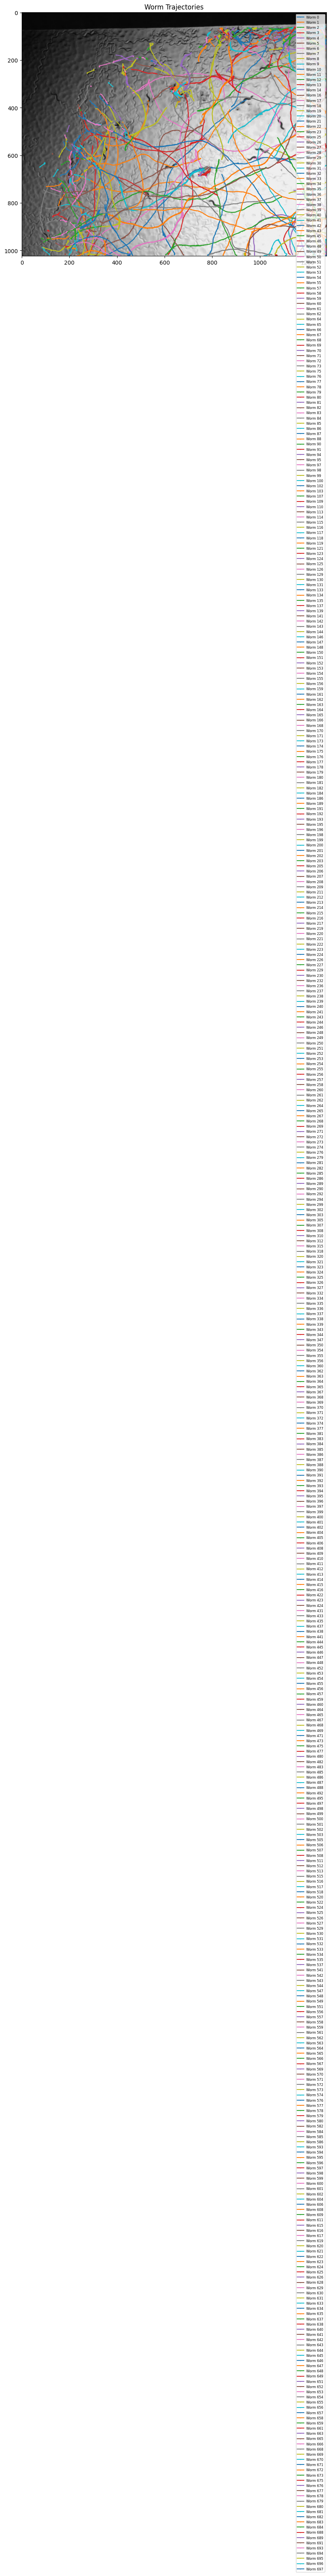

saving tracked centroids to /Users/mikeodonnell/Desktop/OP_N2-04182024152040-0000_results/tracks.csv


In [5]:
# if that looks good, run for the whole video after converting to 8-bit grayscale
if first_frame.shape[-1] == 3:
    first_frame = rgb2gray(first_frame)
    first_frame = (first_frame * 255).astype(np.uint8)
else:
    first_frame = first_frame.astype(np.uint8)

imiter_vid = iio.imiter(fc.selected, plugin = "pyav")
frames = []

start_time = time.time()
for i, frame in enumerate(imiter_vid):
    if i % subsample == 0:
        # print(f"keeping frame {i}")
        print(f"\rKeeping frame: {i}", end="", flush=True)
        time.sleep(0.001)
        if frame.ndim == 3 and frame.shape[-1] == 3:
            if i == 1:
                print("converting to grayscale images")
            frame = rgb2gray(frame)
            frame = (frame * 255).astype(np.uint8)
        elif frame.ndim == 2:
            if i == 1: 
                print("already grayscale, converting to 8-bit")
            frame = frame.astype(np.uint8)
        if backsub == True:
            subtracted = tracking.subtract_background(frame = frame, average_frame = average_frame)
            if i == 0:
                thresh = np.percentile(subtracted, .5)
            frame = subtracted
    # Append the processed frame to the list
        frames.append(frame)
end_time = time.time()
print(f"  Reading in {len(frames)} frames from the full length video took {end_time - start_time} seconds")

# # now simple track for the whole video and link tracks together
print(f"Analyzing {len(frames)} frames")

if thresh is None:
# Compute global threshold
    _, _, global_thresh = tracking.preprocess_frame(first_frame,
                                                    min_area,
                                                    max_area,
                                                    thresh,
                                                    illumination=illumination)
else:
    global_thresh = thresh


detections = tracking.collect_detections(frames, 
                                        global_thresh = global_thresh, 
                                        min_area=min_area, 
                                        max_area=max_area,
                                        illumination=illumination)

# Link tracks
tracks = tracking.link_tracks(detections, search_range=search_range, memory=gap_range, quiet=True)

# Now tracks['particle'] is a persistent worm ID

# visualize the track length of each "worm"
# if there are background particles, this will lead to a ton of short tracks

counts = tracks.groupby("particle")["frame"].count()
print('Mean track length is ',np.ceil(np.mean(counts)/2), ' frames')
print('Minimum track length is ',int(min(counts)))
print('Maximum track length is ',int(max(counts)))
plt.figure(figsize=(10,8))
binwidth = 25
plt.hist(counts, bins=range(int(min(counts)), int(max(counts)) + binwidth, binwidth))
plt.xlabel("length of track in frames")
plt.title("histogram of worm track lengths")
plt.xlabel("length of track in frames \nif too many short tracks, try increasing gap_range, \nif your real worms are disconnected, \nor increase threshold if there are too many small objects")
plt.ylabel("number of worm tracks")
plt.show()

# Remove short tracks
print(f'removing tracks shorter than {min_length} frames')
tracks = tracking.filter_short_tracks(tracks, min_length=min_length)

# Plot over first frame
print('plotting linked and filtered worm tracks')
tracking.plot_trajectories(stack=first_frame, tracks=tracks, output_path=result_path)

# Save the track centroids to a csv file
print(f'saving tracked centroids to {os.path.join(result_path,"tracks.csv")}')
tracks.to_csv(os.path.join(result_path,"tracks.csv"), index=False)


## 5. Below is slow method for posture analysis 

In [1]:
gray = first_frame
print(global_thresh)
search_diameter = round(np.sqrt(max_area)/2) # search diameter for object detection
if search_diameter % 2 == 0:
    search_diameter = search_diameter + 1
# unclear to me why threshold
start_time = time.time()
f = tp.locate(gray, diameter=search_diameter, threshold = (global_thresh/20))
end_time = time.time()
total_time = end_time - start_time
print(f"That one frame took {total_time} seconds")


NameError: name 'first_frame' is not defined

In [ ]:
f.head()

In [ ]:
tp.annotate(f, first_frame);

In [ ]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=10)
ax.set(xlabel='mass', ylabel='count')

In [ ]:
f = tp.batch(frames[:1000], diameter=search_diameter, threshold = (global_thresh/20));

In [ ]:
t = tp.link(f, 50, memory=10)

In [ ]:
t.head()

In [ ]:
plt.figure()
tp.mass_size(t.groupby('particle').mean());

In [ ]:
tp.plot_traj(t)